# Continuous Control Project

---
[//]: # (Image References)

[image1]: ./episode-gifs/example-play-long.gif "Trained Agent"
    
This notebook descripts the results of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893). In this project, we train a set of agents to play tennis in the Unity [Tennis](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Learning-Environment-Examples.md#tennis) environment.


![Trained Agent][image1]

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Each agent receives its own, local observation.  Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

The task is episodic, and in order to solve the environment, the agents must get an average score of +0.5 (over 100 consecutive episodes, after taking the maximum over both agents). Specifically,

- After each episode, we add up the rewards that each agent received (without discounting), to get a score for each agent. This yields 2 (potentially different) scores. We then take the maximum of these 2 scores.
- This yields a single **score** for each episode.

The environment is considered solved, when the average (over 100 episodes) of those **scores** is at least +0.5.


The `README.md` file has information on how to setup the environement.

### Reinforcement Learning Approach

Throughout the following analysis, we build upon the approach of [Deep Deterministic Policy Gradients](https://arxiv.org/abs/1509.02971) (DDPQ).  At core of the DDPG algorithm are two functions: the actor, $\mu(s)$, and the critic, $Q(s,a)$.
The parameterized actor function $\mu(s;\theta_\mu)$ specifies the current policy by deterministically mapping states to a specific action.
The parameterized critic $Q(s, a;\theta_Q)$ is learned using the Bellman equation as in Q-learning. 

We represent the critic using a neutral network $Q(s,a;\theta^{Q\ell})$ that is trained to minimize $\mathbb{E}[(y_i - Q(s,a; \theta_i^{Q\ell}))^2]$ where 

$$y_i=\mathbb{E}[r_i + \gamma Q(s',\mu(s';\theta_i^{\mu t}); \theta^{Qt}_i)|s,a]$$

is known as the target and $\theta^{Qt}_i$ defined the parameters of the target network.
We represent the actor using a neutral network $\mu(s;\theta_i^{\mu \ell})$ that is trained to minimize $-\mathbb{E}[Q(s,\mu(s;\theta_i^{\mu \ell}); \theta_i^{Q\ell}]$.

The target parameters evolve from the local network parameters according to 
$$\theta^t_{i+1} \gets \tau \theta^\ell_{i+1} + (1-\tau)\theta^t_{i}.$$


For the networks used in this analysis, the sequential architecture is as follows for the actors

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fc1_units | relu or leaky relu
fc1_units | fc2_units | relu or leaky relu
fc2_units | action size | tanh

For the critics, the architecture is as follows:

Input Size | Output Size | Activation
---------- | ----------- | ----------
state size | fsc1_units | leaky relu
fsc1_units + action size | fc2_units | leaky relu
fc2_units | 1 | none

This environment has two agents.  In the setup used in the analysis, we use a single network (local-target pair) for the actor and a single network (local-target pair) for the critic.  We use a replay buffer that observes each agent's individual observations--rather than the joint observation.

### Analysis

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os.path
import os
from config import Config

%matplotlib inline

We experiment first on the hyperparameters related to layer size: `fc1_units`, `fsc1_units`, and `fc2_units`:

| fc1_units | fsc1_units | fc2_units
--- | --- | ---
400 | 400 | 300
200 | 200 | 150
100 | 100 | 75

Next, for each internal layer, we consider LazyReLU for the activation function.

Finally, we consider batch sizes of 128 or 256.

In [5]:
experiments = [
    "ddpg-400-300-128bs-100p-01s",
    "ddpg-400-300-128bs-100p-001s",
    "ddpg-400-300-128bs-100p-0001s",
    "ddpg-400-300-128bs-10p-01s",
    "ddpg-400-300-256bs-100p-001s",
    "ddpg-200-150-128bs-100p-001s-3t",
    "ddpg-200-150-128bs-100p-001s-4t",
    "ddpg-100-75-128bs-100p-001s-3t",
    "ddpg-100-75-128bs-100p-001s-4t",
    "ddpg-50-35-128bs-100p-001s-3t",
    "ddpg-50-35-128bs-100p-001s-4t",
    "ddpg-200-150-256bs-100p-001s-3t"
]

def load_experiment(name):
    return pd.read_csv(
        os.path.join('./saved-models',name,'results.csv'),
        header=None,
        names=['episode',name],
        index_col=0)

df = pd.concat(map(load_experiment, experiments), axis=1)

df.head()

,ddpg-400-300-128bs-100p-01s,ddpg-400-300-128bs-100p-001s,ddpg-400-300-128bs-100p-0001s,ddpg-400-300-128bs-10p-01s,ddpg-400-300-256bs-100p-001s,ddpg-200-150-128bs-100p-001s-3t,ddpg-200-150-128bs-100p-001s-4t,ddpg-100-75-128bs-100p-001s-3t,ddpg-100-75-128bs-100p-001s-4t,ddpg-50-35-128bs-100p-001s-3t,ddpg-50-35-128bs-100p-001s-4t,ddpg-200-150-256bs-100p-001s-3t
episode,,,,,,,,,,,,
0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.09,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.1,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.1,0.0
4,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.00,0.0,0.0,0.0


For each experiment configuration, we ran the agent for 1,000 episodes and recorded the scores.  The evolution of the rolling scores are shown the charts below.

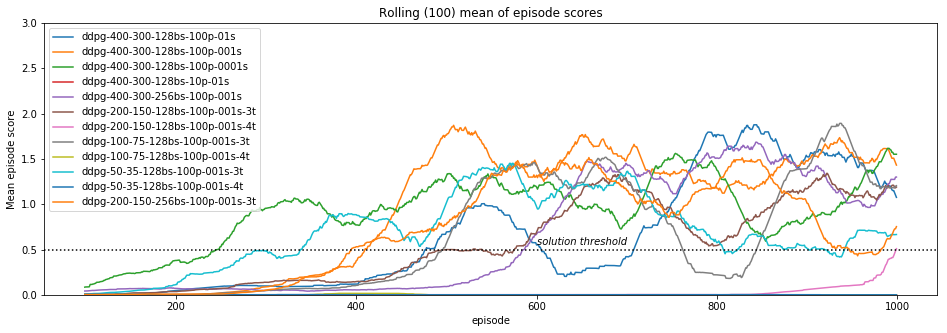

In [16]:
ax = df.rolling(100).mean().plot(title='Rolling (100) mean of episode scores',ylim=(0,3),figsize=(16,5));
ax.set_ylabel("Mean episode score");
ax.text(600, 0.55, 'solution threshold', style='italic');
ax.axhline(y=0.5, color='k', linestyle=':');

The configuration of each setup is denoted within the naming scheme:

`ddpg-{fc1_units}-{fsc1_units}-{batch_size}-{learning_calls_per_episode}-{OU_process_scale_minimum}_{tau_exponent}`

If the $\tau$ exponent is not listed, $10^{-3}$ is used.

We can see that most agent configurations exceed the solution threshold at some time during their evaluation and that `ddpg-400-300-128bs-100p-0001s` solves the environment first (246 episodes) in the samples.

In [17]:
for experiment in experiments:
    solved_index = df[experiment].rolling(100).mean().where(lambda x: x>=0.5).dropna().index.min()
    if not np.isnan(solved_index):
        print('Solved in {1} episodes by {0}.'.format(experiment, solved_index))
    else:
        print('Not solved by {}.'.format(experiment))

Solved in 478 episodes by ddpg-400-300-128bs-100p-01s.
Solved in 410 episodes by ddpg-400-300-128bs-100p-001s.
Solved in 246 episodes by ddpg-400-300-128bs-100p-0001s.
Not solved by ddpg-400-300-128bs-10p-01s.
Solved in 587 episodes by ddpg-400-300-256bs-100p-001s.
Solved in 530 episodes by ddpg-200-150-128bs-100p-001s-3t.
Solved in 999 episodes by ddpg-200-150-128bs-100p-001s-4t.
Solved in 497 episodes by ddpg-100-75-128bs-100p-001s-3t.
Not solved by ddpg-100-75-128bs-100p-001s-4t.
Solved in 338 episodes by ddpg-50-35-128bs-100p-001s-3t.
Not solved by ddpg-50-35-128bs-100p-001s-4t.
Solved in 395 episodes by ddpg-200-150-256bs-100p-001s-3t.


### Closing notes and future work

DQN performed well on this task, solving the environment within 246 episodes.  Using the published layer sizes, among the tested sizes, performed best.  A batch size of 128 performed well.  One of the most significant factors in determining the time to solution was the time when the first positive reward was observed.  This seemed to indicate that early exploration was important.

While not charted, the default scale of 1 for the Ornstein–Uhlenbeck process yields poor results when used for the entire duration.  Exponentially decaying the scale, as was used in all of the listed experiments, help control the time to solution.  It does not seem to significantly influence the results whether the exponential decay was called, from by low, by $10^{-2}$ or $10^{-3}$.

Clipping, both the actor and the network gradients, did seem to improve stability of the algorithm.  The gradient of the final weight layer in actor network, in particular, explodes after the first positive reward.

Finally, using a joint-observation critic may improve stability, altough independent observations seemed to fair just fine.